# Impedance Matching: Practical Design Examples at 1 GHz

This notebook demonstrates practical impedance matching techniques using:
1. Transmission line transformations
2. Series reactive elements (inductors/capacitors)
3. Shunt reactive elements (inductors/capacitors)

All examples use **f = 1 GHz** and **Z₀ = 50Ω** transmission lines.

| Technique | Elements | Advantages | Disadvantages | Best For |
|-----------|----------|------------|---------------|----------|
| **Quarter-Wave** | 1 TL (λ/4) | Simple, no lumped elements | Only for resistive loads, narrowband | Resistive impedance transformation |
| **Series Stub** | 1 TL + 1 Series | Simple, 2 elements | Requires specific TL length | General matching, easy to implement |
| **Shunt Stub** | 1 TL + 1 Shunt | Common in microstrip | Requires specific TL length | Microstrip circuits |
| **L-Network** | 2 Lumped | No TL needed, broadband | Limited Q range | Low frequency, broadband |
| **Double-Stub** | 2 Shunt + 1 TL | Tunable stubs | More complex | Tunable matching systems |

## Key Formulas
The impedance is
$$
Z = R + j X
$$
where R is the resistance and X is the reactance.  

**Reactance to Inductance:**
If X is positive then the equivalent inductance is
$$L = \frac{X}{\omega} = \frac{X}{2\pi f}$$

**Reactance to Capacitance:**
If X is negative, then the equivalent capacitance is
$$C = \frac{1}{\omega |X|} = \frac{1}{2\pi f |X|}$$

**Wavelength:**
If $u_p$ is the phase velocity of in the medium, then the electrical wavelength is
$$\lambda = \frac{u_p}{f} = \frac{3 \times 10^8 \text{ m/s}}{f}$$

Typical values for $u_p$ are $0.66c \approx 2 \times 10^8$ m/s.

**VSWR:**
$$\text{VSWR} = \frac{1 + |\Gamma|}{1 - |\Gamma|}$$

where $\Gamma = \frac{Z_L - Z_0}{Z_L + Z_0}$

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == "emscripten":
    import piplite

    await piplite.install("pysmithchart")

from pysmithchart.constants import Z_DOMAIN, NORM_Y_DOMAIN
from pysmithchart import utils
from pysmithchart.rotation import *
from pysmithchart.utils import cs

# Constants
f = 1e9  # 1 GHz
omega = 2 * np.pi * f
Z0 = 50  # Characteristic impedance
text_box = {"facecolor": "lightyellow", "edgecolor": None}

## Quarter-Wave Transformer to match resistive load

A λ/4 transmission line transforms the load impedance $Z_L$ so that the input impedance of the combination of the λ/4 transformer and load becomes
$$
Z_{in} = \frac{Z_{tr}^2}{Z_L}
$$
where $Z_{tr}$ is the characteristic impedance of the λ/4 transformer.

Matching a 100Ω to a resistive 50Ω load.

In [2]:
Z0 = 50  # impedance of feedline
Z_load = 200 + 0j  # purely resistive load
Z_qw = np.sqrt(Z0 * Z_load)  # impedance of λ/4 TL needed to match Z0
wavelength = 0.25  # λ/4

# Physical length
c = 3e8  # Speed of light m/s
u_p = 0.66 * c  # phase velocity of wave m/s
lambda_m = u_p / f  # wavelength m
length_mm = wavelength * lambda_m * 1000  # λ/4 TL length in mm

z_load = Z_load / Z_qw
z_transformed = rotate_z_by_wavelength(z_load, wavelength)
Z_transformed = z_transformed * Z_qw

print("=" * 60)
print("QUARTER-WAVE TRANSFORMER")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: %s Ω" % cs(Z_load, 0))
print()
print("λ/4 transformer line")
print("   Characteristic Impedance %s Ω" % cs(Z_qw))
print(f"   Physical length: {length_mm:.1f} mm")
print()
print("After λ/4 line")
print(f"   Input impedance:     %s Ω" % cs(Z_transformed))
print(f"   Expected Z₀²/Z_load: %s Ω" % cs(Z_qw**2 / Z_load))
print()

QUARTER-WAVE TRANSFORMER
Frequency: 1.0 GHz
Load impedance:  200 Ω

λ/4 transformer line
   Characteristic Impedance  100 Ω
   Physical length: 49.5 mm

After λ/4 line
   Input impedance:      50 Ω
   Expected Z₀²/Z_load:  50 Ω



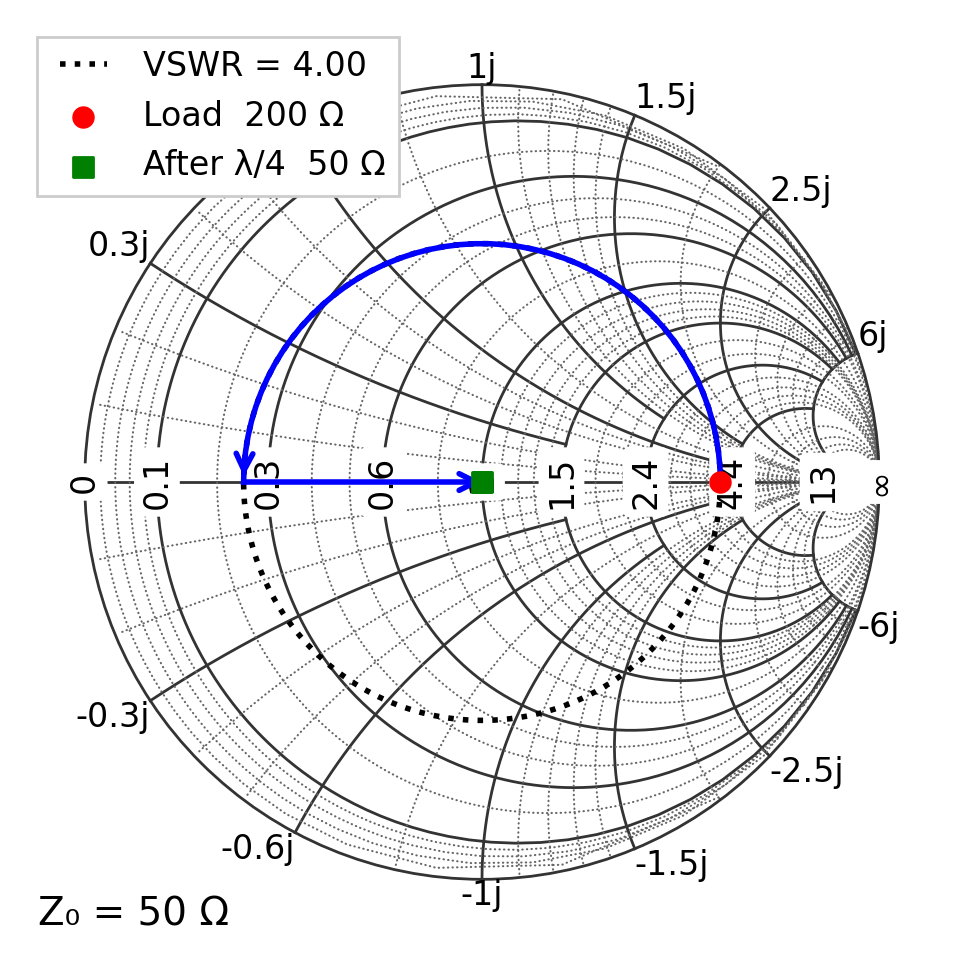

In [3]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

vswr = utils.calc_vswr(Z0, Z_load)
ax.plot_vswr(vswr, "k:", label=f"VSWR = {vswr:.2f}")

# Plot rotation path
ax.plot_rotation_path(Z_load, Z_transformed, "b", linewidth=2, arrow="end")

# Mark points
ax.scatter(Z_load, c="red", s=50, marker="o", label=f"Load %s Ω" % cs(Z_load))
ax.scatter(Z_transformed, c="green", s=50, marker="s", label=f"After λ/4 %s Ω" % cs(Z_transformed))

ax.legend(loc="upper left", framealpha=1)
plt.show()

## Example 2: Single-Stub Matching (Series)

Match a complex load using:
1. Transmission line to rotate to 50Ω
2. Series reactive element to cancel remaining reactance

**Application:** Simple two-element matching network.

In [4]:
Z0 = 50
Z_load = 75 + 100j  # Complex load
z_load = Z_load / Z0

print("=" * 60)
print("EXAMPLE 2: SERIES STUB MATCHING")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load impedance: %s Ω" % cs(Z_load))
print()

# Step 1: Rotate to real axis
z_after_tl = rotate_z_toward_resistance(z_load, 1, solution="closer")
Z_after_tl = z_after_tl * Z0

# Calculate TL length
gamma_load = (z_load - 1) / (z_load + 1)
gamma_tl = (z_after_tl - 1) / (z_after_tl + 1)
angle_diff = np.angle(gamma_tl) - np.angle(gamma_load)
wavelength_tl = (angle_diff / (4 * np.pi)) % 1
length_tl_mm = wavelength_tl * lambda_m * 1000
print(f"Step 1 - After transmission line")
print(f"  z = %s  Ω" % cs(Z_after_tl, 0))
print(f"  TL length: {wavelength_tl:.2f}λ ({length_tl_mm:.1f} mm)")
print()

# Step 2: Series reactance to cancel and match to 50Ω
X_series = -Z_after_tl.imag  # Cancel reactance
R_parallel_needed = Z_after_tl.real - Z0  # Additional resistance transformation needed

comp_type, comp_value, comp_unit = utils.reactance_to_component(X_series, f)
print(f"Step 2 - Series element:")
print(f"  Reactance needed: {X_series:+.2f} Ω")
print(f"  Component: {comp_type} = {comp_value:.2f} {comp_unit}")
print()

# Final impedance
Z_final = Z_after_tl.real + 1j * (Z_after_tl.imag + X_series)
z_final = Z_final / Z0
print(f"Final impedance: {Z_final:.2f} Ω")

EXAMPLE 2: SERIES STUB MATCHING
Frequency: 1.0 GHz
Load impedance:  75 +  100j Ω

Step 1 - After transmission line
  z =  50 +  84j  Ω
  TL length: 0.02λ (3.5 mm)

Step 2 - Series element:
  Reactance needed: -84.16 Ω
  Component: Capacitor = 1.89 pF

Final impedance: 50.00+0.00j Ω


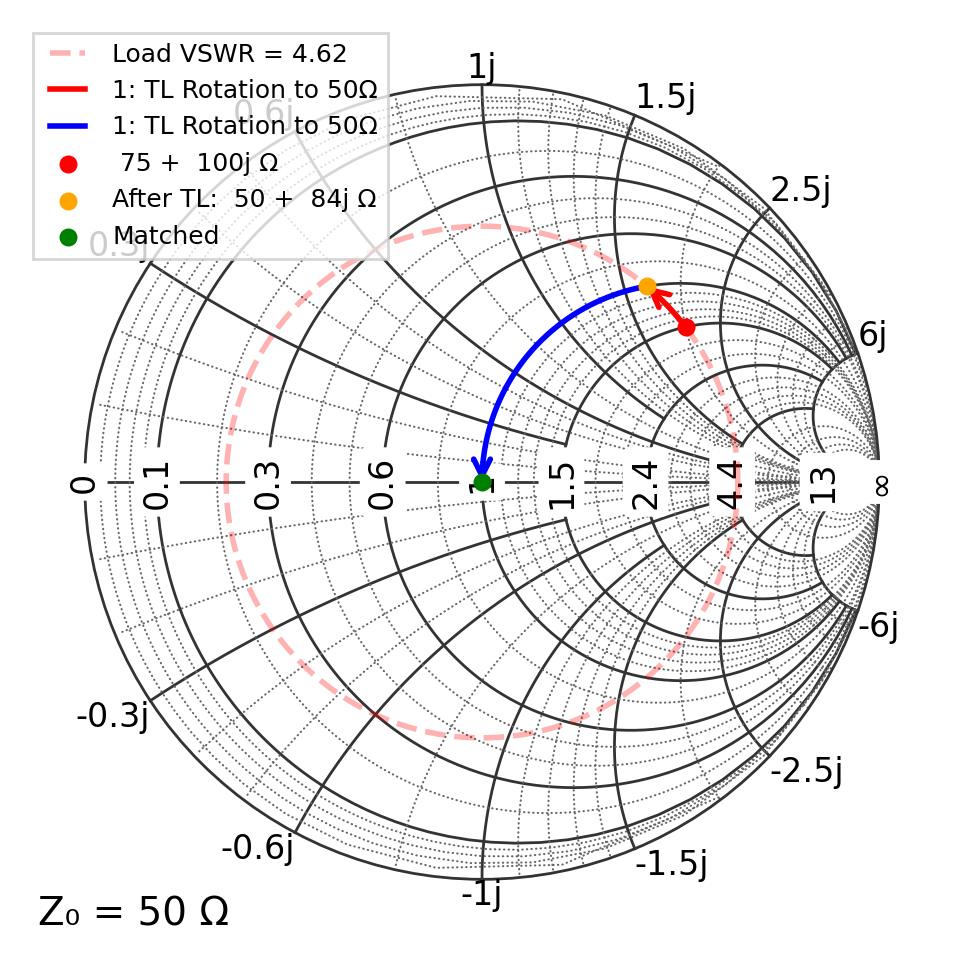

In [5]:
vswr = utils.calc_vswr(Z0, Z_load)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot_vswr(vswr, "r--", alpha=0.3, label=f"Load VSWR = {vswr:.2f}")
ax.plot_rotation_path(Z_load, Z_after_tl, "r-", lw=2, arrow="end", label="1: TL Rotation to 50Ω")

Z_plot = np.array([Z_after_tl, Z_final])
ax.plot_constant_resistance(
    1, "b-", range=(z_after_tl.imag, z_final.imag), lw=2, arrow="end", label="1: TL Rotation to 50Ω"
)


ax.scatter(Z_load, c="red", s=30, label=f"%s Ω" % cs(Z_load))
ax.scatter(Z_after_tl, c="orange", s=30, label=f"After TL: %s Ω" % cs(Z_after_tl, 0))
ax.scatter(Z_final, c="green", s=30, label=f"Matched")

ax.legend(loc="upper left", fontsize=9)
plt.show()

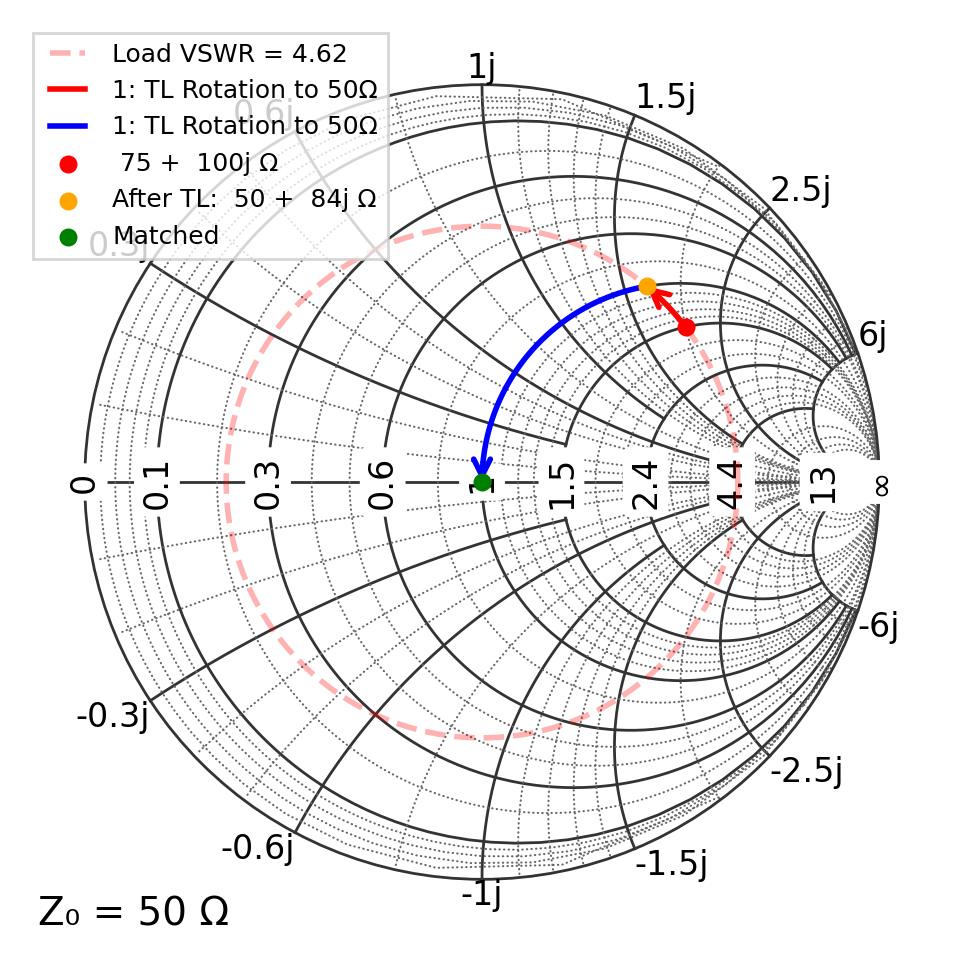

In [6]:
vswr = utils.calc_vswr(Z0, Z_load)

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith")

ax.plot_vswr(vswr, "r--", alpha=0.3, label=f"Load VSWR = {vswr:.2f}")
ax.plot_rotation_path(Z_load, Z_after_tl, "r-", lw=2, arrow="end", label="1: TL Rotation to 50Ω")

Z_plot = np.array([Z_after_tl, Z_final])
ax.plot_constant_resistance(
    1, "b-", range=(z_after_tl.imag, z_final.imag), lw=2, arrow="end", label="1: TL Rotation to 50Ω"
)

ax.scatter(Z_load, c="red", s=30, label=f"%s Ω" % cs(Z_load))
ax.scatter(Z_after_tl, c="orange", s=30, label=f"After TL: %s Ω" % cs(Z_after_tl, 0))
ax.scatter(Z_final, c="green", s=30, label=f"Matched")

ax.legend(loc="upper left", fontsize=9)
plt.show()

## Example 3: Single-Stub Matching (Shunt)

Match using:
1. Transmission line to rotate to conductance = 1/Z₀
2. Shunt reactive element to cancel susceptance

**Application:** Common in microstrip circuits where shunt stubs are easier to implement.

In [7]:
Z0 = 50
Y0 = 1 / Z0
y_load = 0.5 + 0.6j
Y_load = y_load * Y0

Z_load = 1 / Y_load

print("=" * 60)
print("EXAMPLE 3: SHUNT STUB MATCHING")
print("=" * 60)
print(f"Frequency: {f/1e9:.1f} GHz")
print(f"Load admittance: {Y_load*1000:.3f} mS")
print(f"Norm admittance: {y_load:.3f}")
print(f"Load impedance:  {Z_load:.1f} Ω")
print()

# Step 1: Rotate to G = Y0 (g=1)
# Convert to impedance for the rotation function
y_after_tl = rotate_y_toward_conductance(y_load, 1, solution="closer")
Y_after_tl = y_after_tl * Y0
Z_after_tl = 1 / Y_after_tl

print(f"Step 1 - After transmission line:")
print(f"  Target conductance: {Y0*1000:.3f} mS")
print(f"  Admittance:         {Y_after_tl*1000:.3f} mS")
print(f"  Norm Admittance:    {y_after_tl:.2f}")

# Calculate TL length
gamma_load = (Z_load / Z0 - 1) / (Z_load / Z0 + 1)
gamma_tl = (Z_after_tl / Z0 - 1) / (Z_after_tl / Z0 + 1)
angle_diff = np.angle(gamma_tl) - np.angle(gamma_load)
wavelength_tl = (angle_diff / (4 * np.pi)) % 1
length_tl_mm = wavelength_tl * lambda_m * 1000
print(f"  TL length:          {wavelength_tl:.4f}λ ({length_tl_mm:.2f} mm)")
print()

# Step 2: Shunt susceptance to cancel
B_shunt = -Y_after_tl.imag  # Susceptance to cancel
X_shunt = -1 / B_shunt if B_shunt != 0 else 0  # Reactance of shunt element

comp_type, comp_value, comp_unit = utils.reactance_to_component(X_shunt, f)
print(f"Step 2 - Shunt element:")
print(f"  Susceptance needed: {B_shunt*1000:+.3f} mS")
print(f"  Equivalent reactance: {X_shunt:+.2f} Ω")
print(f"  Component: {comp_type} = {comp_value:.2f} {comp_unit}")
print()

# Final admittance
Y_final = Y_after_tl + 1j * B_shunt
y_final = Y_final / Y0
Z_final = 1 / Y_final
print(f"Final normalized y: {y_final:.2f}")
print(f"Final impedance:    {Z_final:.2f} Ω")

EXAMPLE 3: SHUNT STUB MATCHING
Frequency: 1.0 GHz
Load admittance: 10.000+12.000j mS
Norm admittance: 0.500+0.600j
Load impedance:  41.0-49.2j Ω

Step 1 - After transmission line:
  Target conductance: 20.000 mS
  Admittance:         20.000+22.091j mS
  Norm Admittance:    1.00+1.10j
  TL length:          0.9348λ (185.10 mm)

Step 2 - Shunt element:
  Susceptance needed: -22.091 mS
  Equivalent reactance: +45.27 Ω
  Component: Inductor = 7.20 nH

Final normalized y: 1.00+0.00j
Final impedance:    50.00+0.00j Ω


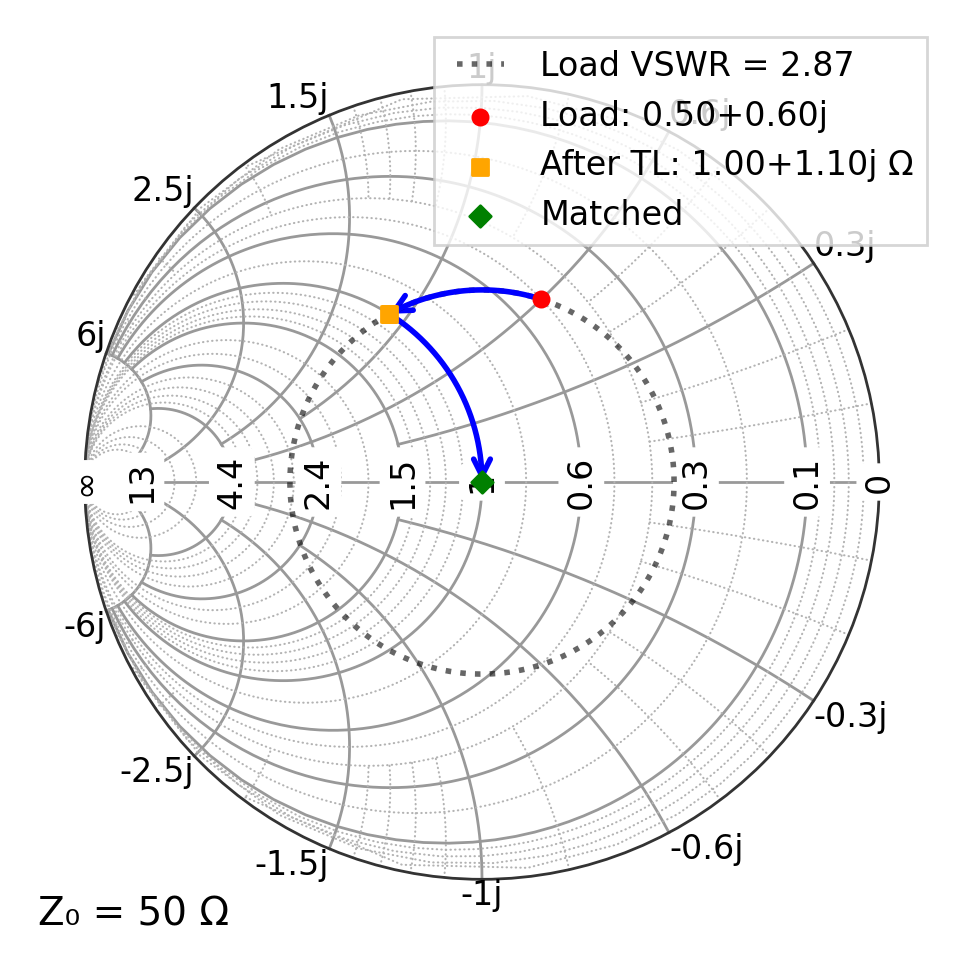

In [8]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection="smith", grid="admittance", domain=NORM_Y_DOMAIN)

vswr = utils.calc_vswr(Z0, Z_load)
ax.plot_vswr(vswr, "k:", alpha=0.6, label=f"Load VSWR = {vswr:.2f}")

ax.plot_rotation_path(y_load, y_after_tl, "b", linewidth=2, arrow="end")
ax.plot_constant_conductance(1, "b", range=(y_after_tl.imag, y_final.imag), lw=2, arrow="end")

ax.scatter(y_load, c="red", s=30, marker="o", label=f"Load: {y_load:.2f}")
ax.scatter(y_after_tl, c="orange", s=30, marker="s", label=f"After TL: {y_after_tl:.2f} Ω")
ax.scatter(y_final, c="green", s=30, marker="D", label=f"Matched", zorder=10)

ax.legend(loc="upper right")
# ax.set_title("Smith Chart View (Impedance)", fontsize=12, fontweight="bold")
plt.show()

## Example 4: L-Network Matching (Series-Shunt)

Two-element L-network using:
1. Series reactive element
2. Shunt reactive element

**Application:** Broadband matching without transmission lines (good for low frequencies).

```                                                         
   +────50Ω─────+────────[X_series]─────+────[X_cancel]────+
   |            |                                          |
   |            |                                          | 
[Generator]  [X_shunt]                                  [Load]  
   |            |                                          |  
   |            |                                          |
  ===          ===                                        ===
  GND          GND                                        GND
                ↑                                          ↑
         Input impedance                                At load
           (want 50Ω)
```

we can combine the two reactances in series to get


```                                                         
   +────50Ω─────+────[X_series + X_cancel]────+
   |            |                             |
   |            |                             | 
[Generator]  [X_shunt]                     [Load]  
   |            |                             |  
   |            |                             |
  ===          ===                           ===
  GND          GND                           GND
```


In [9]:
f = 1e9
Z0 = 50
Z_load = 25 + 100j

# Step 1: cancel load reactance (series)
X_cancel = -Z_load.imag
Z1 = Z_load + 1j * X_cancel  # 25 + 0j

comp_type, comp_value, comp_unit = utils.reactance_to_component(X_cancel, f)
print(f"X_cancel needed:")
print(f"  Reactance needed: {X_cancel:+.3f} Ω")
print(f"  Component: {comp_type} = {comp_value:.2f} {comp_unit}")
print()

# Step 2: Q (valid now that Z1 is real)
R = Z1.real
Q = np.sqrt(Z0 / R - 1)

# Series-first L-match values (for R < Z0)
X_series_mag = Q * R  # 25
X_shunt_mag = R * (1 + Q**2) / Q  # 50   <-- key fix

comp_type, comp_value, comp_unit = utils.reactance_to_component(X_series, f)
print(f"X_series needed:")
print(f"  Reactance needed: {X_series:+.3f} Ω")
print(f"  Component: {comp_type} = {comp_value:.2f} {comp_unit}")
print()

for sgn in (+1, -1):
    Xs_total = X_cancel + sgn * X_series_mag  # -75 or -125
    # choose shunt sign to cancel susceptance after series step
    Z2 = Z_load + 1j * Xs_total
    Y2 = 1 / Z2
    B_needed = -Y2.imag  # cancel imag(Y)
    Xp = -1 / B_needed  # since B = -1/X for jX
    Y_final = Y2 + 1 / (1j * Xp)
    Z_final = 1 / Y_final

    print(f"Xs_total = {Xs_total:+.2f} Ω, Xp = {Xp:+.2f} Ω  ->  Z_final = {Z_final}")

X_cancel needed:
  Reactance needed: -100.000 Ω
  Component: Capacitor = 1.59 pF

X_series needed:
  Reactance needed: -84.163 Ω
  Component: Capacitor = 1.89 pF

Xs_total = -75.00 Ω, Xp = -50.00 Ω  ->  Z_final = (50+0j)
Xs_total = -125.00 Ω, Xp = +50.00 Ω  ->  Z_final = (50+0j)


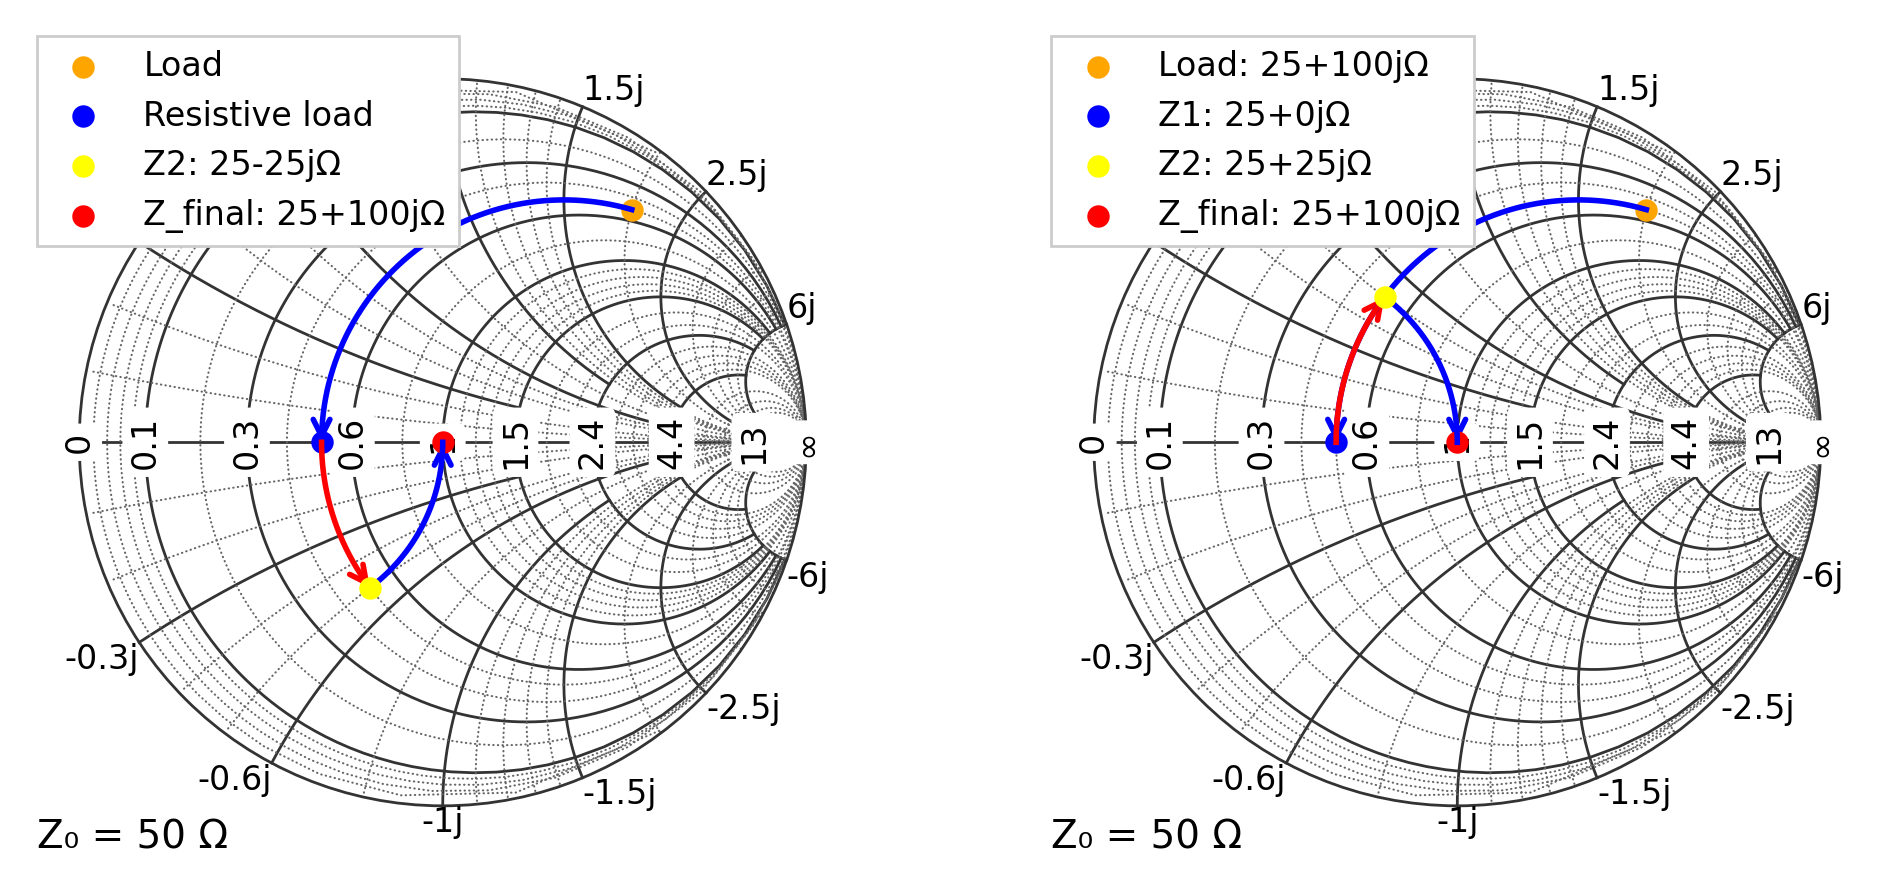

In [11]:
z_load = Z_load / Z0
z1 = Z1 / Z0
z2 = Z2 / Z0

y_load = 1 / z_load
y1 = 1 / z1
y2 = 1 / z2

vswr = utils.calc_vswr(Z0, Z_load)

plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection="smith")

ax.scatter(Z_load, c="orange", s=50, marker="o", label=f"Load")
ax.scatter(Z1, c="blue", s=50, marker="o", label=f"Resistive load")
ax.scatter(Z2, c="yellow", s=50, marker="o", label=f"Z2: {Z2:.0f}Ω", zorder=10)
ax.scatter(Z_final, c="red", s=50, marker="o", label=f"Z_final: {Z_load:.0f}Ω")

ax.plot_constant_resistance(z_load.real, "b-", range=(z_load.imag, 0), arrow="end")
ax.plot_constant_resistance(z_load.real, "r-", range=(0, z2.imag), arrow="end")
ax.plot_constant_conductance(y2.real, "b-", range=(-y2.imag, 0), arrow="end")

ax.legend(loc="upper left", framealpha=1.0)

Z2 = np.conjugate(Z2)
z2 = Z2 / Z0
y2 = 1 / z2
ax = plt.subplot(122, projection="smith")

ax.scatter(Z_load, c="orange", s=50, marker="o", label=f"Load: {Z_load:.0f}Ω")
ax.scatter(Z1, c="blue", s=50, marker="o", label=f"Z1: {Z1:.0f}Ω")
ax.scatter(Z2, c="yellow", s=50, marker="o", label=f"Z2: {Z2:.0f}Ω", zorder=10)
ax.scatter(Z_final, c="red", s=50, marker="o", label=f"Z_final: {Z_load:.0f}Ω")

ax.plot_constant_resistance(z_load.real, "b-", range=(z_load.imag, 0), arrow="end")
ax.plot_constant_resistance(z_load.real, "r-", range=(0, z2.imag), arrow="end")
ax.plot_constant_conductance(y2.real, "b-", range=(-y2.imag, 0), arrow="end")

ax.legend(loc="upper left", framealpha=1.0)

plt.show()

## Example 5: Double-Stub Matching

Two shunt stubs separated by λ/8 transmission line.  The stub lengths can be adjusted.
The feedline and both stubs have a characteristic impedance of 50 Ω.

```                                                         
   +────50Ω─────+────────[λ/8 spacing line]─────+─────────+
   |            |               50Ω             |         |
   |            |                               |         |
[Generator]  [Stub 2]                        [Stub 1]   [Load]
   |            |                               |         |
   |            |                               |         |
  ===          ===                             ===       ===
  GND          GND                             GND       GND
                ↑                                                ↑
         Input impedance                                      At load
           (want 50Ω)
```

The stubs can only add reactance to the circuit so process will use admittances
moving from the load to the generator

```
 Load          Stub 1       Spacing        Stub 2        Input
y_load    →    [+jb₁]   →    [λ/8]    →    [+jb₂]   →   y_in=1+0j
0.4-0.2j        +jb₁         rotate         +jb₂         1+0j
                 ↓             ↓
              y_needed    y_target_on_g1
              at_stub1
```

In [12]:
Z0 = 50
Z_load = 80 + 60j
z_load = Z_load / Z0
y_load = 1 / z_load  # Normalized admittance

stub_spacing = 0.125  # λ/8 spacing

print("=" * 60)
print("EXAMPLE 5: DOUBLE-STUB MATCHING")
print("=" * 60)
print(f"Frequency:       {f/1e9:.1f} GHz")
print(f"Load impedance:  {Z_load:.1f} Ω")
print(f"Load admittance: {y_load:.3f}")
print(f"Stub spacing:    {stub_spacing}λ")
print()

# STEP 1: Rotate load by spacing
y_load_rotated = rotate_y_by_wavelength(y_load, stub_spacing, direction="toward_load")
print(f"Load rotated by {stub_spacing}λ: y = {y_load_rotated:.3f}")

# STEP 2: Try to find target on g=1 circle
try:
    y_target_on_g1 = rotate_y_toward_conductance(y_load_rotated, 1.0, solution="closer")
    print(f"Target on g=1 circle: y = {y_target_on_g1:.3f}")
except Exception as e:
    print(f"ERROR: Cannot reach g=1 circle - {e}")
    print("Load may be in FORBIDDEN REGION")
    y_target_on_g1 = None

if y_target_on_g1 is None:
    print("\nNo solution exists for this load with this stub spacing")
else:
    # STEP 3: Work backwards
    y_after_stub1_target = rotate_y_by_wavelength(y_target_on_g1, stub_spacing, direction="toward_generator")
    print(f"Need after stub1: y = {y_after_stub1_target:.3f}")

    # STEP 4: Check conductance match
    g_error = abs(y_after_stub1_target.real - y_load.real)
    if g_error > 0.05:  # 5% tolerance
        print(f"\nWARNING: Conductance mismatch (error = {g_error:.3f})")
        print(f"  Need g = {y_after_stub1_target.real:.3f}")
        print(f"  Have g = {y_load.real:.3f}")
        print(f"  Trying alternate solution...")

        # Try the other solution
        try:
            y_target_on_g1 = rotate_y_toward_conductance(y_load_rotated, 1.0, solution="farther")
            print(f"Alternate target on g=1: y = {y_target_on_g1:.3f}")
            y_after_stub1_target = rotate_y_by_wavelength(y_target_on_g1, stub_spacing, direction="toward_generator")
            print(f"Need after stub1: y = {y_after_stub1_target:.3f}")

            g_error = abs(y_after_stub1_target.real - y_load.real)
            if g_error > 0.05:
                print(f"\nERROR: No valid solution for this stub spacing")
                print(f"Load is in FORBIDDEN REGION for {stub_spacing}λ spacing")
                y_target_on_g1 = None
        except Exception as e:
            print(f"ERROR: {e}")
            y_target_on_g1 = None

    if y_target_on_g1 is not None:
        # Calculate stub 1
        b_stub1 = y_after_stub1_target.imag - y_load.imag
        print(f"\nFirst stub (at load):")
        print(f"  Adds susceptance: b = {b_stub1:+.3f}")

        # Convert to stub length
        if abs(b_stub1) < 1e-10:
            stub1_length = 0.25
        else:
            beta_l = np.arctan(-1 / b_stub1)
            if beta_l < 0:
                beta_l += np.pi
            stub1_length = beta_l / (2 * np.pi)

        print(f"  Stub length: {stub1_length:.4f}λ = {stub1_length * 360:.1f}°")

        # Apply stub 1
        y_after_stub1 = y_load + 1j * b_stub1
        print(f"\nAfter stub 1: y = {y_after_stub1:.3f}")

        # Rotate by spacing
        y_after_spacing = rotate_y_by_wavelength(y_after_stub1, stub_spacing, direction="toward_load")
        print(f"\nAfter spacing line ({stub_spacing}λ): y = {y_after_spacing:.3f}")
        print(f"  Conductance g = {y_after_spacing.real:.3f} (should be ≈ 1.0)")

        # Stub 2 cancels susceptance
        b_stub2 = -y_after_spacing.imag
        print(f"\nSecond stub:")
        print(f"  Adds susceptance: b = {b_stub2:+.3f}")

        if abs(b_stub2) < 1e-10:
            stub2_length = 0.25
        else:
            beta_l = np.arctan(-1 / b_stub2)
            if beta_l < 0:
                beta_l += np.pi
            stub2_length = beta_l / (2 * np.pi)

        print(f"  Stub length: {stub2_length:.4f}λ = {stub2_length * 360:.1f}°")

        # Final result
        y_final = y_after_spacing + 1j * b_stub2
        z_final = 1 / y_final
        Z_final = z_final * Z0

        print(f"\nFinal admittance: {y_final:.3f}")
        print(f"Final impedance: {Z_final:.2f} Ω")
        vswr_final = utils.calc_vswr(Z0, Z_final)
        print(f"Final VSWR: {vswr_final:.4f}:1")

        print("\n" + "=" * 60)
        print("DOUBLE STUB DESIGN SUMMARY")
        print("=" * 60)
        print(f"Stub 1 (at load):    {stub1_length:.4f}λ = {stub1_length * 360:.1f}°")
        print(f"Spacing line:        {stub_spacing}λ")
        print(f"Stub 2 (at input):   {stub2_length:.4f}λ = {stub2_length * 360:.1f}°")
        print("=" * 60)

EXAMPLE 5: DOUBLE-STUB MATCHING
Frequency:       1.0 GHz
Load impedance:  80.0+60.0j Ω
Load admittance: 0.400-0.300j
Stub spacing:    0.125λ

Load rotated by 0.125λ: y = 1.231-1.154j
Target on g=1 circle: y = 1.000-1.061j
Need after stub1: y = 0.381-0.214j

First stub (at load):
  Adds susceptance: b = +0.086
  Stub length: 0.2636λ = 94.9°

After stub 1: y = 0.400-0.214j

After spacing line (0.125λ): y = 1.029-1.022j
  Conductance g = 1.029 (should be ≈ 1.0)

Second stub:
  Adds susceptance: b = +1.022
  Stub length: 0.3767λ = 135.6°

Final admittance: 1.029+0.000j
Final impedance: 48.57+0.00j Ω
Final VSWR: 1.0295:1

DOUBLE STUB DESIGN SUMMARY
Stub 1 (at load):    0.2636λ = 94.9°
Spacing line:        0.125λ
Stub 2 (at input):   0.3767λ = 135.6°


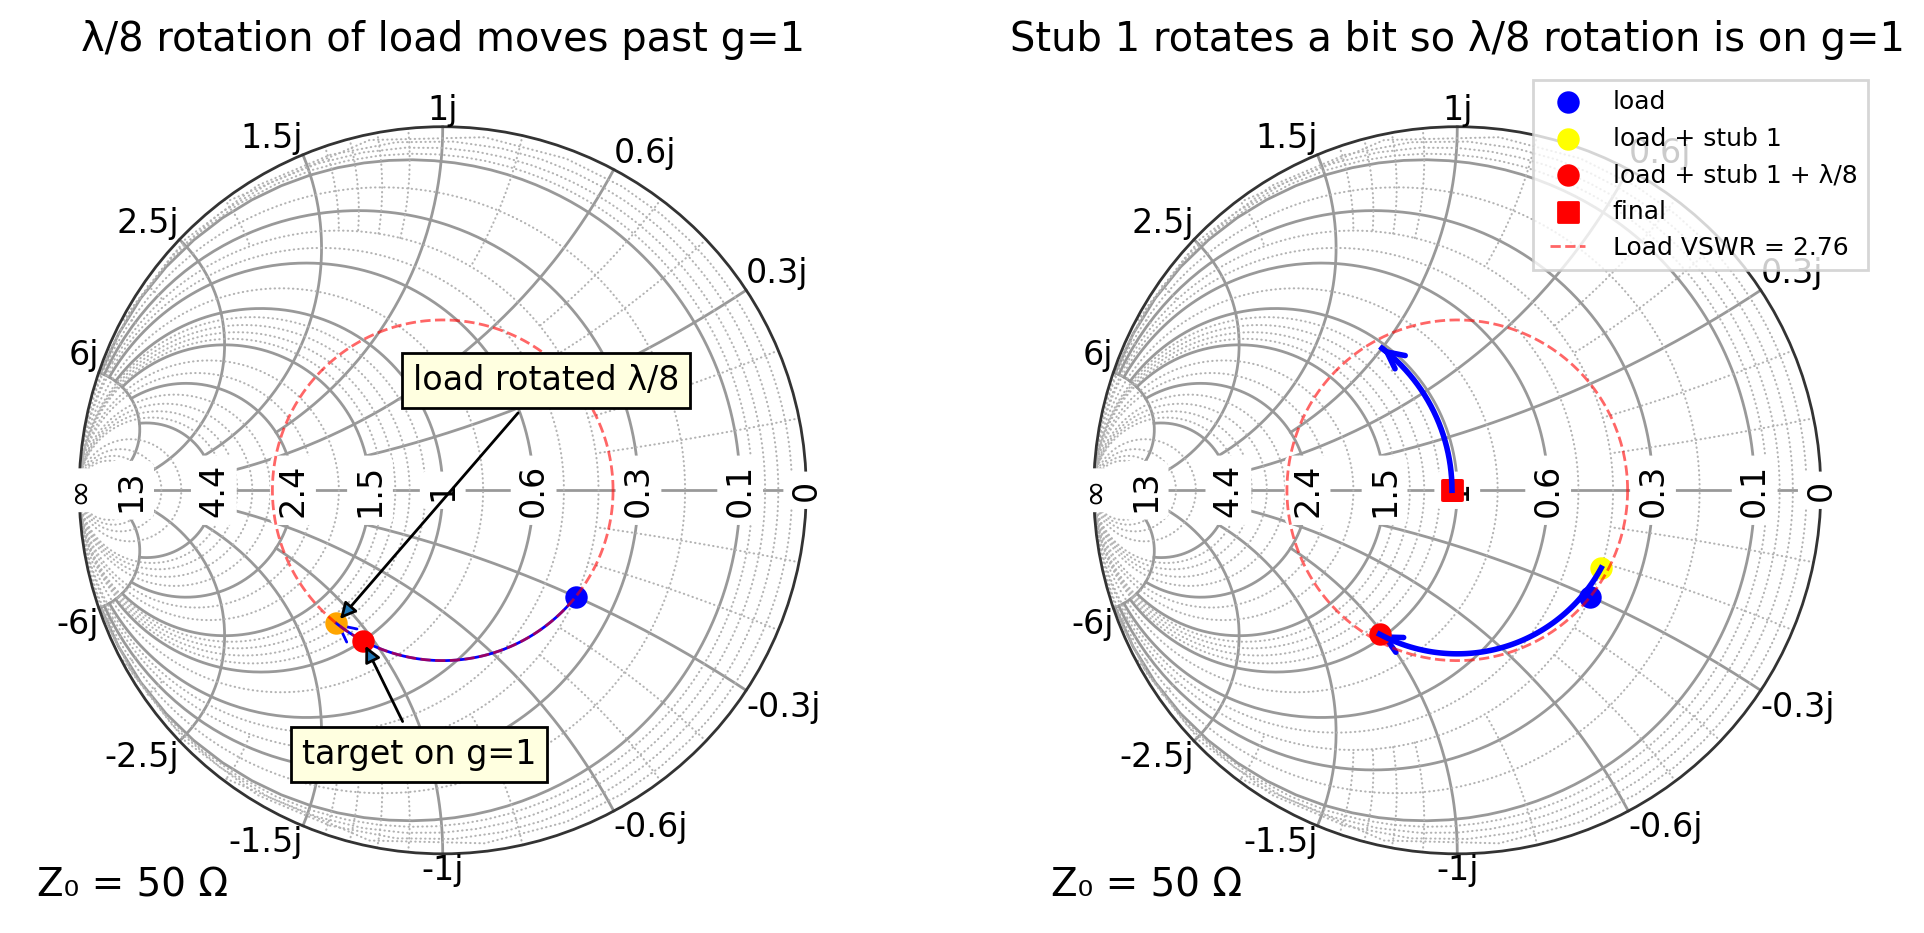

In [13]:
Z0 = 50
Z_load = 80 + 60j
z_load = Z_load / Z0
y_load = 1 / z_load  # Normalized admittance

stub_spacing = 0.125  # λ/8 spacing

plt.figure(figsize=(12, 6))
ax = plt.subplot(121, projection="smith", grid="admittance", domain=NORM_Y_DOMAIN)
ax.scatter(y_load, c="blue", s=50, marker="o", label="load")
ax.scatter(y_load_rotated, c="orange", s=50, marker="o", label="load rotated λ/8")
ax.plot_rotation_path(y_load, y_load_rotated, "blue", linewidth=1, arrow="end", label=f"{stub_spacing}λ Line")
ax.scatter(y_target_on_g1, c="red", s=50, marker="o", label="target on g=1")
ax.annotate(
    "target on g=1",
    (y_target_on_g1.real, y_target_on_g1.imag),
    xytext=(0.3, -1.6),
    arrowprops=dict(arrowstyle="-|>"),
    bbox=text_box,
    zorder=10,
)
ax.annotate(
    "load rotated λ/8",
    (y_load_rotated.real, y_load_rotated.imag),
    xytext=(1, 0.6),
    arrowprops=dict(arrowstyle="-|>"),
    bbox=text_box,
    zorder=10,
)
ax.set_title("λ/8 rotation of load moves past g=1")

vswr = utils.calc_vswr(Z0, Z_load)
ax.plot_vswr(vswr, "r--", alpha=0.6, lw=1, label=f"Load VSWR = {vswr:.2f}")

ax = plt.subplot(122, projection="smith", grid="admittance", domain=NORM_Y_DOMAIN)
ax.scatter(y_load, c="blue", s=50, marker="o", label="load")
ax.scatter(y_after_stub1, c="yellow", s=50, marker="o", label="load + stub 1")
ax.scatter(y_after_spacing, c="red", s=50, marker="o", label="load + stub 1 + λ/8")
ax.scatter(y_final, c="red", s=50, marker="s", label="final")
ax.plot_rotation_path(y_after_stub1, y_after_spacing, "blue", lw=2, arrow="end")
ax.plot_constant_conductance(y_after_spacing, "blue", lw=2, range=(0, 1), arrow="end")
ax.set_title("Stub 1 rotates a bit so λ/8 rotation is on g=1")
vswr = utils.calc_vswr(Z0, Z_load)
ax.plot_vswr(vswr, "r--", alpha=0.6, lw=1, label=f"Load VSWR = {vswr:.2f}")

ax.legend(loc="upper right", fontsize=9)

plt.show()